 ## PEDESTRIAN CLASSIFICATION SECTION

### A -  Library importation

In [1]:
import sys
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing                                                               
from sklearn.model_selection import train_test_split                                             
import shutil
import glob,os,random
import cv2
import keras
from keras import layers,models
from keras.optimizers import SGD
from keras.utils import load_img,img_to_array,array_to_img,plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,GlobalAveragePooling2D
from keras.models import Sequential,load_model
import tensorflow as tf
from keras.applications import ResNet50
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")


### B - Loading image directories

In [2]:
# For Mac OS to remove .DS_Store file in folder


# import os

# directory_path = "TRAIN_"
# ds_store_path = os.path.join(directory_path, ".DS_Store")

# if os.path.exists(ds_store_path):
#     os.remove(ds_store_path)

In [3]:
# Set the path to the directory containing training data
train_path = "TRAIN_"

# List the contents (files and subdirectories) of the specified directory
# and store the list of item names in the 'train_path' variable
os.listdir(train_path)

['person_not_walking_train', 'person_walking_train']

In [4]:
# Set the path to the directory containing test data
test_path = "TEST_"

# List the contents (files and subdirectories) of the specified directory
# and store the list of item names in the 'test_path' variable
os.listdir(test_path)

['person_not_walking_test', 'person_walking_test']

### C - Checking the number of images in test and train dataset - Data Exploration

In [5]:
# 'train_pest_images' will store the paths to all JPEG image files found in the specified directories
# The 'os.path.join(parent_path, "*/*.jpg")' creates a file path pattern that matches
# all JPEG files within subdirectories under 'train_path'
train_pest_images = glob.glob(os.path.join(train_path,"*/*.jpg"))

# Print the number of pest images found
print(f"There are {len(train_pest_images)} available in the training dataset" )

There are 844 available in the training dataset


In [6]:
# 'test_pest_images' will store the paths to all JPEG image files found in the specified directories
# The 'os.path.join(parent_path, "*/*.jpg")' creates a file path pattern that matches
# all JPEG files within subdirectories under 'test_path'
test_pest_images = glob.glob(os.path.join(test_path,"*/*.jpg"))

# Print the number of pest images found
print(f"There are {len(test_pest_images)} available in the testing dataset" )

There are 100 available in the testing dataset


### D - Preview the Dataset  - Data Exploration

Find Sample Images below:


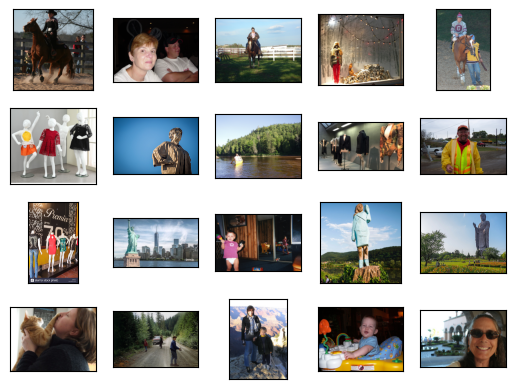

In [7]:
print("Find Sample Images below:")

# Select and process a random sample of 15 image file paths from the 'train_pest_images' list
for index,path in enumerate(random.sample(train_pest_images,20)):
    image = load_img(path)
    image = img_to_array(image,dtype = np.uint8)
    plt.subplot(4,5,index + 1)
    plt.imshow(image.squeeze())
    plt.rcParams["figure.figsize"] = (15,15)
    plt.grid(visible = None)
    plt.xticks([])
    plt.yticks([])

### E - Image Preprocessing - Data Augumentation

In [8]:
# Create an ImageDataGenerator for training data with various augmentation options
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to [0, 1]
    rotation_range=30,  # Randomly rotate images within the range of [-30, 30] degrees
    shear_range=0.15,  # Apply shear transformation with a shear intensity of 0.15
    zoom_range=0.15,  # Randomly zoom in/out by up to 15%
    width_shift_range=0.1,  # Randomly shift the width by up to 10%
    height_shift_range=0.1,  # Randomly shift the height by up to 10%
 #   horizontal_flip=True,  # Flip images horizontally
 #   vertical_flip=True,  # Flip images vertically
    validation_split=0.2,  # Split 20% of the data for validation
    fill_mode='nearest'  # Fill empty areas after transformations using nearest neighbors
)

# Create an ImageDataGenerator for test data with simple rescaling
test_data_generator = ImageDataGenerator(
    rescale=1./255  # Scale pixel values to [0, 1]
)

### F - Training and Validation Dataset creation

In [9]:
# Define the desired input shape for the images
input_shape = (256, 256)
# Define the batch size for training/testing
batch_size = 64


# Create Training Dataset
train_dataset = train_data_generator.flow_from_directory(
    train_path,         # Directory containing the training data
    target_size=input_shape,  # Desired input image dimensions (e.g., (256, 256))
    batch_size=batch_size,    # Number of images per batch during training (e.g., 64)
    class_mode="binary", # Type of labels ("categorical" for one-hot encoded labels)
    subset="training",   
    shuffle=False,    # Subset of the data to use (in this case, "training" subset)
    seed=123                 # Seed for reproducibility
)


# Create Validation Dataset
validation_dataset = train_data_generator.flow_from_directory(
    train_path,           # Directory containing the validation or test data
    target_size=input_shape,  # Desired input image dimensions (e.g., (256, 256))
    batch_size=batch_size,    # Number of images per batch during validation/testing (e.g., 64)
    class_mode="binary", # Type of labels ("categorical" for one-hot encoded labels)
    subset="validation",      # Subset of the data to use (in this case, "validation" subset)        # Do not shuffle the data (important for validation/testing)
    seed=123                  # Seed for reproducibility
)



Found 788 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


### G - Store the different labels the Pests

In [10]:
# Get the dictionary of class indices from the training dataset
pest_class_dict = train_dataset.class_indices

# Extract the pest names (pest_class) from the dictionary using a list comprehension
# 'pest' corresponds to the class name, and 'index' corresponds to the class index
pest_class = [pest for pest, index in pest_class_dict.items()]

print("==================================================")
print("The Labels have been extracted successfully")

The Labels have been extracted successfully


### H - Deep CNN Neural Network - 1 Convolutional Block, 1 Dense Layer

In [11]:

# Define input shape, batch size, number of classes and learning rate
input_shape = (256, 256, 3)
batch_size = 64
num_classes = 1
learning_rate = 0.001 
epoch_ = 10


# Create the model
model = models.Sequential()

# Layer 1: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))  # Downsample and reduce spatial dimensions
model.add(layers.BatchNormalization())  # Normalize outputs for stable training

# Flatten feature maps and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))  # Fully connected layer
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='sigmoid'))  # Output layer


In [12]:
# Compile the model with a specific learning rate
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Use the Adam optimizer with the specified learning rate
    loss='binary_crossentropy',  # Specify the loss function
    metrics=['accuracy']  # Specify evaluation metrics
)

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 64)      256       
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1032256)           0         
                                                                 
 dense (Dense)               (None, 256)               264257792 
                                                                 
 dropout (Dropout)           (None, 256)               0

In [13]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=epoch_, # Number of training epochs
    validation_data=validation_dataset # Validation dataset generator
)

Epoch 1/10
13/13 [==============================] - 20s 1s/step - loss: 83.0487 - accuracy: 0.7360 - val_loss: 25.1841 - val_accuracy: 0.8564
Epoch 2/10
13/13 [==============================] - 20s 1s/step - loss: 29.9294 - accuracy: 0.8604 - val_loss: 11.5288 - val_accuracy: 0.8513
Epoch 3/10
13/13 [==============================] - 19s 1s/step - loss: 17.0721 - accuracy: 0.8718 - val_loss: 1.5910 - val_accuracy: 0.8513
Epoch 4/10
13/13 [==============================] - 19s 1s/step - loss: 10.4309 - accuracy: 0.8439 - val_loss: 2.1048 - val_accuracy: 0.8615
Epoch 5/10
13/13 [==============================] - 19s 1s/step - loss: 8.6768 - accuracy: 0.8515 - val_loss: 0.7953 - val_accuracy: 0.8615
Epoch 6/10
13/13 [==============================] - 19s 1s/step - loss: 4.6920 - accuracy: 0.9036 - val_loss: 2.3908 - val_accuracy: 0.8564
Epoch 7/10
13/13 [==============================] - 20s 2s/step - loss: 3.9594 - accuracy: 0.8579 - val_loss: 1.7790 - val_accuracy: 0.8615
Epoch 8/10
13/

In [14]:
# Create function to plot evaluation graphs as this will be done repeatedly in this study
def plot_graph(history, type):
    plt.figure(figsize=(7, 5)) 
    if type == 'accuracy':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

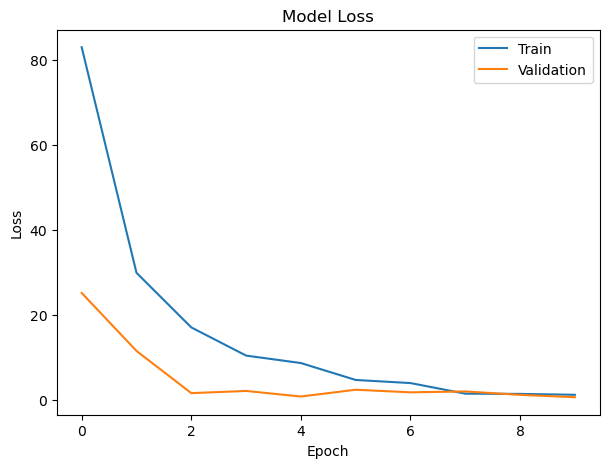

In [15]:
# Plot Model Loss graph
plot_graph(history,'loss')

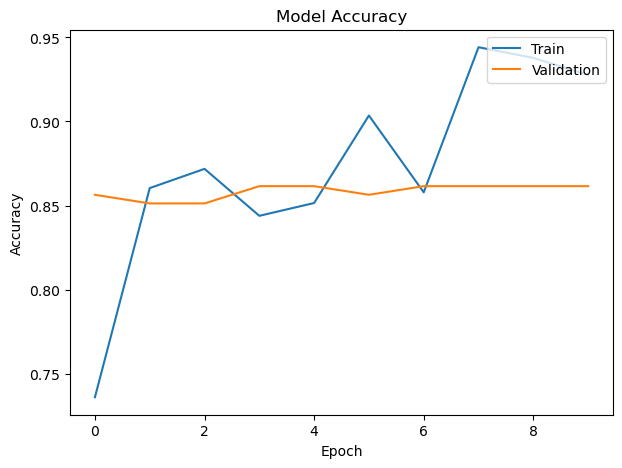

In [16]:
# Plot Model accuracy graph
plot_graph(history,'accuracy')

In [17]:
# Create Function to print accuracy and loss of model as it will be utilized repeatedly
def evalaution_metrics(name,model):
    loss,accuracy = model.evaluate(validation_dataset,verbose=0)
    print(f"The accuracy of the {name} model is {accuracy:.4f}")
    print(f"The loss of the {name} model is {loss:.4f}")

In [18]:
# Evaluate model
evalaution_metrics('CNN(No Transfer Learning)',model )

The accuracy of the CNN(No Transfer Learning) model is 0.8615
The loss of the CNN(No Transfer Learning) model is 0.6420


### I - Deep CNN Neural Network - 2 Convolutional Block, 1 Dense Layer

In [19]:
# Define input shape, batch size, number of classes and learning rate
input_shape = (256, 256, 3)
batch_size = 64
num_classes = 1
learning_rate = 0.001 
epoch_ = 10


# Create the model
model = models.Sequential()

# Layer 1: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))  # Downsample and reduce spatial dimensions
model.add(layers.BatchNormalization())  # Normalize outputs for stable training

# Layer 2: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Flatten feature maps and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))  # Fully connected layer
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='sigmoid'))  # Output layer


In [20]:
# Compile the model with a specific learning rate
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Use the Adam optimizer with the specified learning rate
    loss='binary_crossentropy',  # Specify the loss function
    metrics=['accuracy']  # Specify evaluation metrics
)

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 127, 127, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                      

In [21]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=epoch_, # Number of training epochs
    validation_data=validation_dataset # Validation dataset generator

)

Epoch 1/10
13/13 [==============================] - 43s 3s/step - loss: 45.9259 - accuracy: 0.7640 - val_loss: 2.5334 - val_accuracy: 0.8513
Epoch 2/10
13/13 [==============================] - 41s 3s/step - loss: 34.0297 - accuracy: 0.8490 - val_loss: 18.6032 - val_accuracy: 0.8410
Epoch 3/10
13/13 [==============================] - 42s 3s/step - loss: 32.3043 - accuracy: 0.8477 - val_loss: 6.7340 - val_accuracy: 0.8513
Epoch 4/10
13/13 [==============================] - 41s 3s/step - loss: 22.2132 - accuracy: 0.8794 - val_loss: 12.1494 - val_accuracy: 0.8615
Epoch 5/10
13/13 [==============================] - 41s 3s/step - loss: 19.3155 - accuracy: 0.9048 - val_loss: 14.4969 - val_accuracy: 0.5641
Epoch 6/10
13/13 [==============================] - 41s 3s/step - loss: 15.8410 - accuracy: 0.9099 - val_loss: 44.2781 - val_accuracy: 0.1641
Epoch 7/10
13/13 [==============================] - 41s 3s/step - loss: 15.9936 - accuracy: 0.8997 - val_loss: 9.2223 - val_accuracy: 0.8564
Epoch 8/1

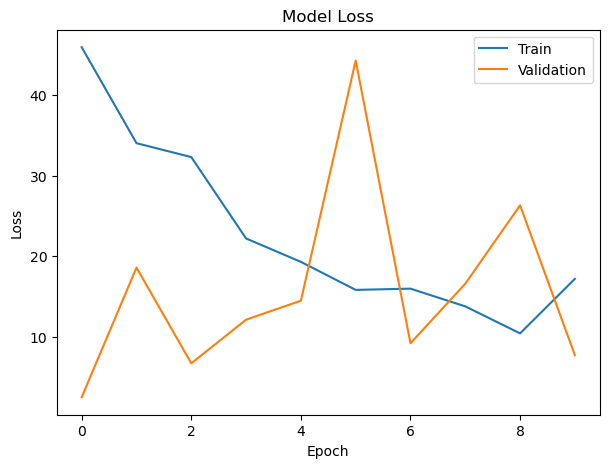

In [22]:
# Plot Model Loss graph
plot_graph(history,'loss')

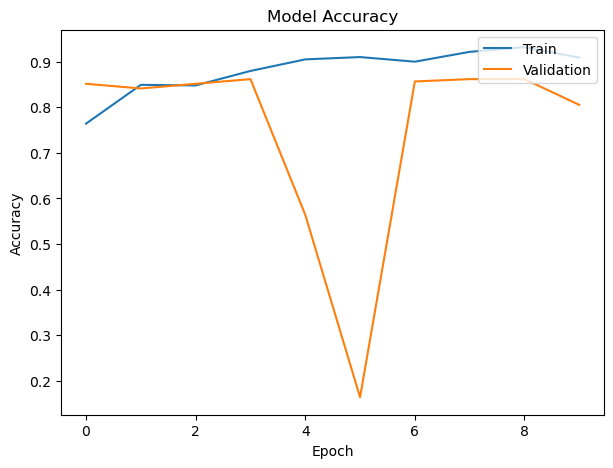

In [23]:
# Plot Model accuracy graph
plot_graph(history,'accuracy')

In [24]:
# Evaluate model
evalaution_metrics('CNN(No Transfer Learning)',model )

The accuracy of the CNN(No Transfer Learning) model is 0.7949
The loss of the CNN(No Transfer Learning) model is 7.6448


### J - Deep CNN Neural Network - 3 Convolutional Block, 1 Dense Layer

In [25]:

# Define input shape, batch size, number of classes and learning rate
input_shape = (256, 256, 3)
batch_size = 64
num_classes = 1
learning_rate = 0.001 
epoch_ = 10


# Create the model
model = models.Sequential()

# Layer 1: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))  # Downsample and reduce spatial dimensions
model.add(layers.BatchNormalization())  # Normalize outputs for stable training

# Layer 2: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Layer 3: Convolutional + MaxPooling + BatchNormalization
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Flatten feature maps and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))  # Fully connected layer
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='sigmoid'))  # Output layer


In [26]:
# Compile the model with a specific learning rate
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Use the Adam optimizer with the specified learning rate
    loss='binary_crossentropy',  # Specify the loss function
    metrics=['accuracy']  # Specify evaluation metrics
)

# Print a summary of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 127, 127, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                      

In [27]:
# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=epoch_, # Number of training epochs
    validation_data=validation_dataset # Validation dataset generator

)

Epoch 1/10
13/13 [==============================] - 55s 4s/step - loss: 23.1558 - accuracy: 0.7360 - val_loss: 2.3556 - val_accuracy: 0.8615
Epoch 2/10
13/13 [==============================] - 54s 4s/step - loss: 10.5016 - accuracy: 0.8503 - val_loss: 4.2239 - val_accuracy: 0.7538
Epoch 3/10
13/13 [==============================] - 53s 4s/step - loss: 13.5136 - accuracy: 0.8566 - val_loss: 7.2281 - val_accuracy: 0.8615
Epoch 4/10
13/13 [==============================] - 52s 4s/step - loss: 10.0166 - accuracy: 0.8934 - val_loss: 17.4854 - val_accuracy: 0.8615
Epoch 5/10
13/13 [==============================] - 54s 4s/step - loss: 9.9539 - accuracy: 0.8909 - val_loss: 13.6039 - val_accuracy: 0.8615
Epoch 6/10
13/13 [==============================] - 54s 4s/step - loss: 6.7101 - accuracy: 0.9213 - val_loss: 17.0500 - val_accuracy: 0.8615
Epoch 7/10
13/13 [==============================] - 52s 4s/step - loss: 9.0779 - accuracy: 0.8731 - val_loss: 38.3168 - val_accuracy: 0.1487
Epoch 8/10
1

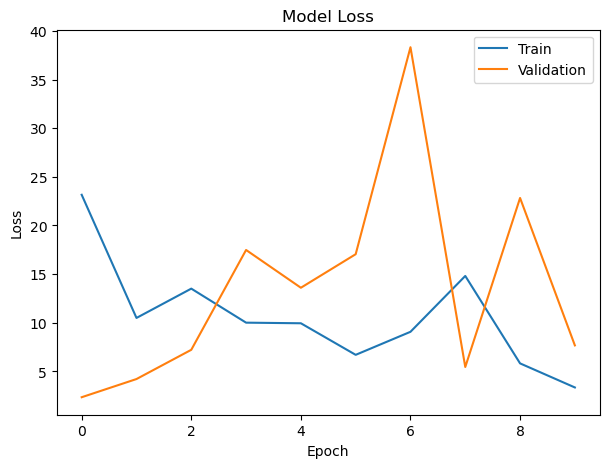

In [28]:
# Plot Model Loss graph
plot_graph(history,'loss')

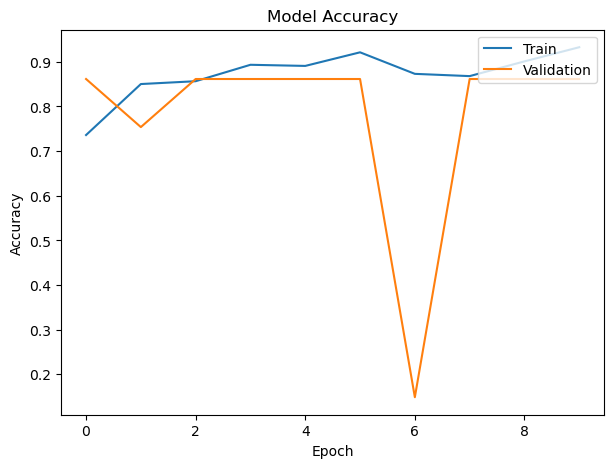

In [29]:
# Plot Model accuracy graph
plot_graph(history,'accuracy')

In [30]:
# Create Function to print accuracy and loss of model as it will be utilized repeatedly
def evalaution_metrics(name,model):
    loss,accuracy = model.evaluate(validation_dataset,verbose=0)
    print("=======================")
    print(f"The accuracy of the {name} model is {accuracy:.4f}")
    print("=======================")
    print(f"The loss of the {name} model is {loss:.4f}")

In [31]:
# Evaluate model
evalaution_metrics('CNN(No Transfer Learning)',model )

The accuracy of the CNN(No Transfer Learning) model is 0.8615
The loss of the CNN(No Transfer Learning) model is 8.2755


### K - Deep CNN Neural Network - ResNet152V2; Learning rate = 0.001

In [38]:
# Create a function to handle model computations as simlar architecture will be used to test different transfer learning architectures

# Create model architecture
def create_model_arch(tran_learn_arch):
    for layer in tran_learn_arch.layers:
        layer.trainable = False

    # Add custom layer on top of the pre-trained model
    # Flatten the output of the pre-trained model's convolutional layers
    x = Flatten()(tran_learn_arch.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Add another fully connected dense layer with 1024 units and ReLU activation
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Add the final output layer for your specific task
    model_layers = Dense(num_classes, activation='sigmoid')(x)

    # Create the final custom model
    # The input is the same as the input of the pre-trained model, and the output is the newly defined output layer
    model = Model(inputs=tran_learn_arch.input, outputs=model_layers)
    return model


# Create a function to compile the model and modify the learning rate
def compile_model(model,learning_rate):
    model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Use the Adam optimizer with the specified learning rate
    loss='binary_crossentropy',  # Specify the loss function
    metrics=['accuracy']  # Specify evaluation metrics
    )

    # Print a summary of the model architecture
    model.summary()
    return model
    

In [39]:
# Initialize a ResNet152V2 model for transfer learning with specific settings:
model = ResNet152V2(input_shape=(256,256, 3),pooling='avg',weights = 'imagenet',include_top=False)

# Using model functions created earlier:
model = create_model_arch(model)
model = compile_model(model,0.001)

# Train the model using callbacks
history = model.fit(
    train_dataset, # Training dataset generator
    epochs=epoch_, # Number of training epochs
    validation_data=validation_dataset # Validation dataset generator
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 64, 64, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 32, 32, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, 32, 32, 512)          0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, 32, 32, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, 32, 32, 512)          0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, 34, 34, 128)          0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 32, 32, 128)          147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 16, 16, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, 16, 16, 1024)         4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, 18, 18, 256)          0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, 16, 16, 256)          589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, 16, 16, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, 16, 16, 256)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, 16, 16, 1024)         0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, 16, 16, 1024)         4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, 16, 16, 1024)         0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, 16, 16, 256)          262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, 18, 18, 256)          0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, 16, 16, 256)          589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, 16, 16, 256)          1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, 8, 8, 1024)           0         ['max_pooling2d_11[0][0]',    
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, 8, 8, 1024)           0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, 10, 10, 512)          0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

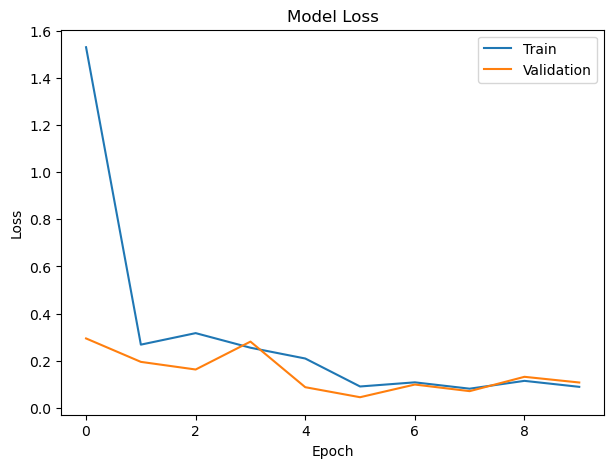

In [40]:
# Plot Model Loss graph
plot_graph(history,'loss')

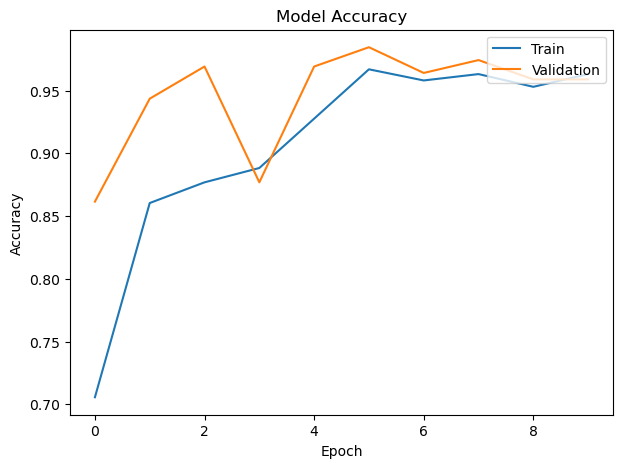

In [41]:
# Plot Model Accuracy graph
plot_graph(history,'accuracy')

In [42]:
# Evaluate Model
evalaution_metrics('CNN(ResNet152V2 Transfer Learning)',model )

The accuracy of the CNN(ResNet152V2 Transfer Learning) model is 0.9538
The loss of the CNN(ResNet152V2 Transfer Learning) model is 0.1159


### TEST THE BEST CLASSIFICATION MODEL

In [55]:
# Load and preprocess your test dataset
test_dataset = test_data_generator.flow_from_directory(
    test_path,
    target_size= (256,256),
    batch_size=64,
    class_mode='binary',  # Assuming it's a multi-class classification task
    shuffle=False  # To maintain order for predictions
)

Found 130 images belonging to 2 classes.


In [57]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset, verbose=0)

predictions = [1 if pred>0.5 else 0 for pred in predictions]

# Get predicted labels and true labels
# predicted_labels = np.argmax(predictions, axis=1)
# true_labels = test_dataset.classes

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"The Model(ResNet152V2) is was tested and achieved the accuracy of: {accuracy:.4f}")


In [58]:
# Calculate classification report
report = classification_report(true_labels, predictions, target_names=pest_class)

# Print the classification report table
print("Classification Report:")
print("=========================")
print(" ")
print(report)

Classification Report:
 
                          precision    recall  f1-score   support

person_not_walking_train       0.94      1.00      0.97       100
    person_walking_train       1.00      0.80      0.89        30

                accuracy                           0.95       130
               macro avg       0.97      0.90      0.93       130
            weighted avg       0.96      0.95      0.95       130



In [62]:
loss, accuracy = model.evaluate(test_dataset, verbose = 0)
print("The Loss and Accuracy of the ResNet152V2 Transfer Learning ")
print(f"Evaluation Loss: {loss}")
print(f"Evaluation Accuracy: {accuracy}")

Evaluation Loss: 0.17402541637420654
Evaluation Accuracy: 0.9538461565971375


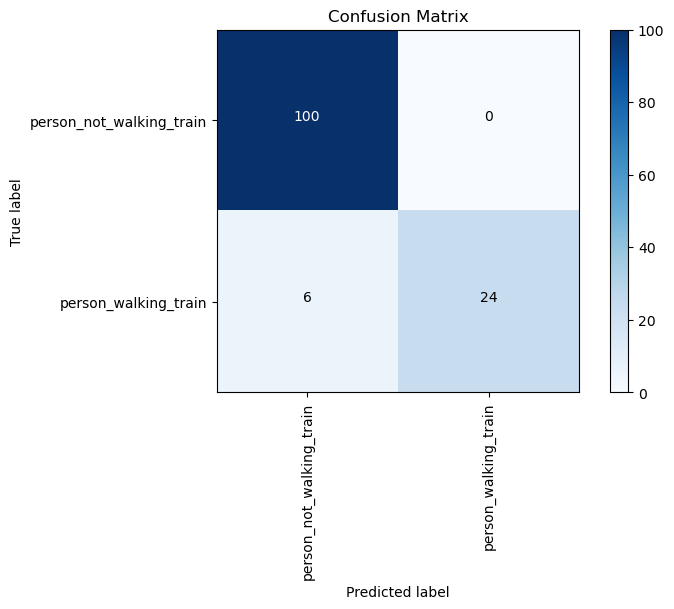

In [60]:
# Generate a confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Plot the matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Define tick marks for the class labels on x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # Add text annotations to each cell of the matrix
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Label the axes and ensure tight layout
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define the class names for labeling the matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=pest_class, title='Confusion Matrix')
plt.show()

## OBJECT DETECTION SECTION

### A - Library Importation

In [63]:
# Import necessary libraries
import cv2  # OpenCV library for computer vision tasks
import matplotlib.pyplot as plt  # Matplotlib for plotting images
import numpy as np  # NumPy for numerical operations

### B - Choose Deep Learning Technique

In [64]:
# Load YOLO pre-trained model weights and configuration using OpenCV
yolo = cv2.dnn.readNet("yolov3.weights","yolov3.cfg")

In [65]:
# Create an empty list to store class names
classes = []

# Open and read the "coco.names" file
with open ("coco.names", 'r') as f:
    classes = f.read().splitlines()

### C - Available Classes in the Technique


In [66]:
# Inspect class labels
classes 

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [67]:
# Print the length of the labels to know how many labels there are.
len(classes)

80

### D - Image Visualization

In [68]:
# Read an image file named "woman_crossing.jpeg" and store it in the 'image' variable
image  = cv2.imread("woman_crossing.jpeg")

In [69]:
# Generate a blob (binary large object) from the input image using OpenCV's deep neural network (dnn) module
blob = cv2.dnn.blobFromImage(
    image,            # Input image
    1/255,             # Scale factor to divide pixel values by (normalization)
    (320, 320),        # Size to which the image will be resized before passing through the network
    (0, 0, 0),         # Mean subtraction values for each channel (R, G, B)
    swapRB=True,       # Flag to indicate whether to swap red and blue channels
    crop=False         # Flag to indicate whether to perform center cropping
)

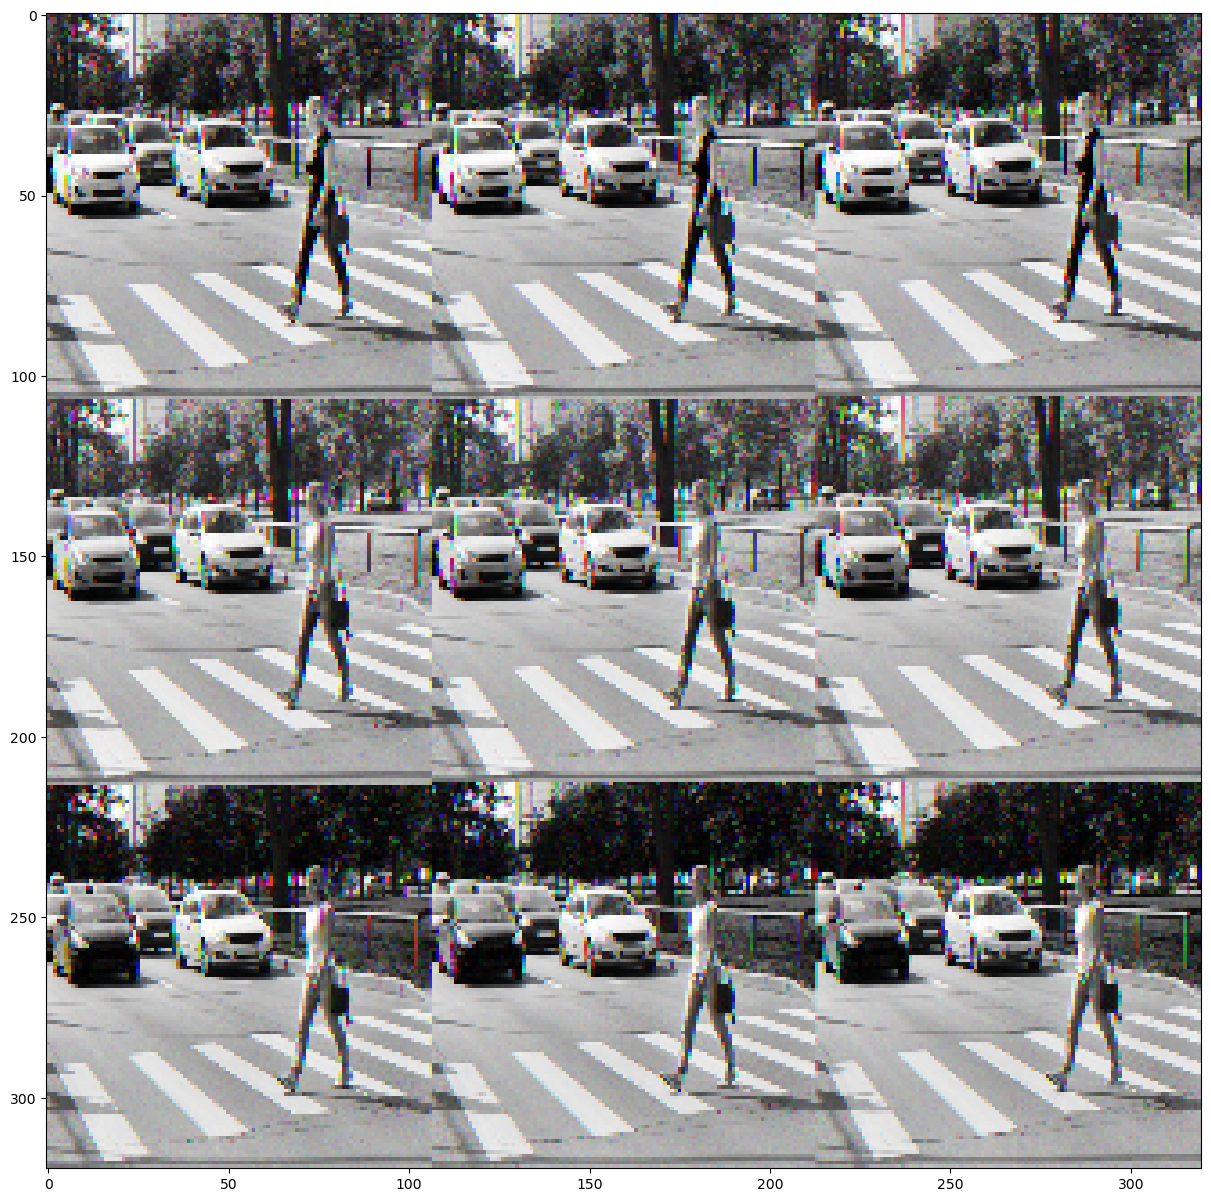

In [70]:
# Reshape the first entry in the blob to the original image dimensions
i = blob[0].reshape(320,320,3)

# Display the reshaped image using matplotlib
plt.imshow(i)

In [71]:
# Set the input blob for the YOLO (You Only Look Once) model
yolo.setInput(blob)

In [72]:
# Get the names of the unconnected output layers from the YOLO model
output_layer_names = yolo.getUnconnectedOutLayersNames()

# Forward pass the input blob through the YOLO model to get the output predictions
layer_output = yolo.forward(output_layer_names)

### E - Configuration Set up

In [73]:
# Initialize empty lists to store bounding box coordinates, confidences, and class IDs
boxes = []
confidences = []
class_ids = []

# Get the dimensions of the input image
height, width, channels = image.shape

In [74]:
# Iterate through each output from the YOLO model's layers
for output in layer_output:
    # Iterate through each detection in the output
    for detection in output:
        # Extract scores for classes and find the class with the highest score
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        
        # Filter out weak predictions (confidence threshold set to 0.6)
        if confidence > 0.6:
            # Scale the coordinates and dimensions back to the original image size
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            
            # Calculate the top-left corner of the bounding box
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            
            # Store the bounding box coordinates, confidence, and class ID
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [75]:
# Apply non-maximum suppression to filter out overlapping bounding boxes
indexes = cv2.dnn.NMSBoxes(boxes, confidences,score_threshold=0.5,nms_threshold=0.2)

In [76]:
# Define the font for text annotations
font = cv2.FONT_HERSHEY_PLAIN

# Generate random colors for each class label
colors = np.random.uniform(0, 255, size=(len(boxes), 3))

### F - Detection

In [77]:
# Iterate through the selected bounding box indexes
for selected_image in indexes.flatten():
    # Extract bounding box coordinates
    x, y, w, h = boxes[selected_image]
    
    # Get the predicted class label
    label = str(classes[class_ids[selected_image]])
    
    # Check if the label corresponds to specific classes (classes[0] and classes[16])
    if label == classes[0] or label == classes[16]:
        # Get the confidence score for the detection
        confi = str(round(confidences[selected_image], 1))
        
        # Get the color associated with the class
        color = colors[selected_image]
        
        # Draw a rectangle around the detected object
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
        
        # Add text annotation with class label and confidence
        cv2.putText(image, label + " " + confi, (x, y + 20), font, 2, (255, 255, 255), 2)

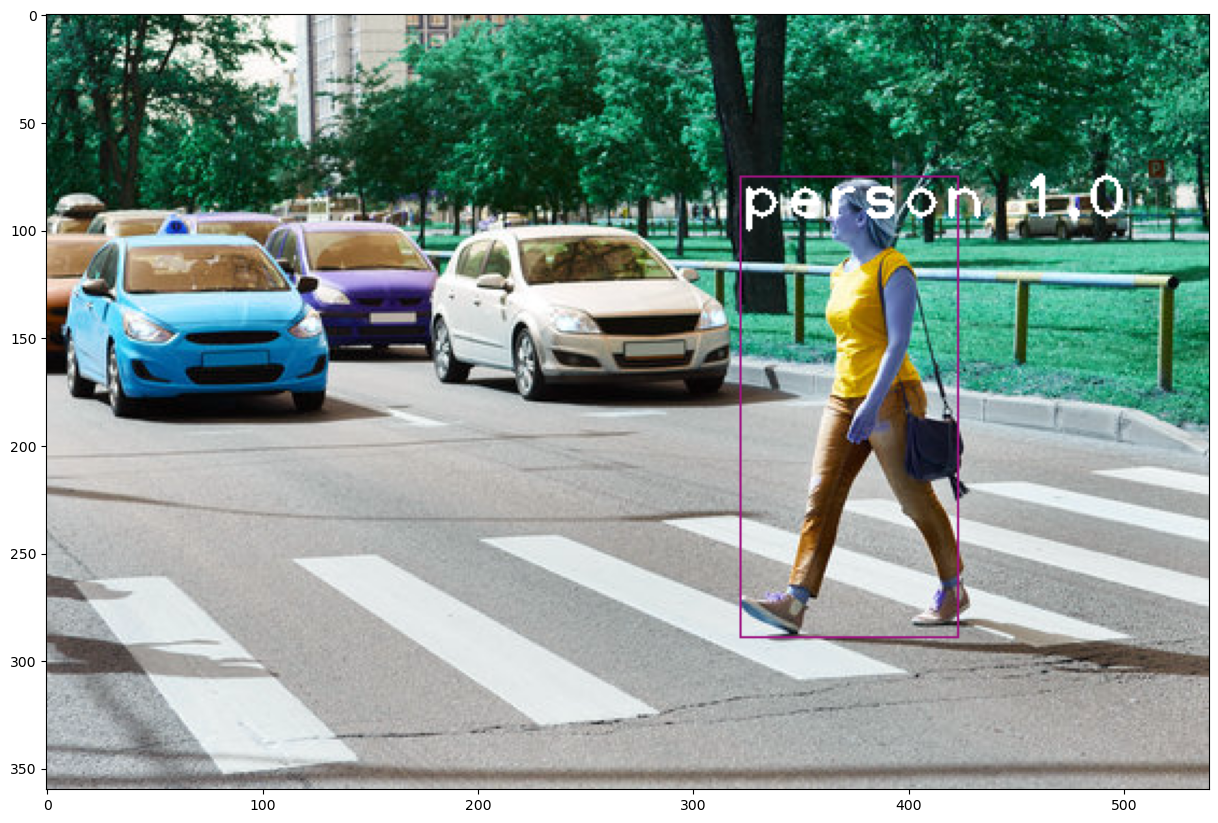

In [78]:
# Display the image with annotations using OpenCV
plt.imshow(image)

### F - Create Detection Method

In [79]:
def detectPedestrains(imagePath):
    # Initialize a count to keep track of detected people
    people_count = 0
    
    # Load the image from the specified path
    image = cv2.imread(imagePath)
    
    # Convert the image to RGB format for matplotlib compatibility
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create a blob from the image for YOLO model input
    blob = cv2.dnn.blobFromImage(image, 1/255, (320, 320), (0, 0, 0), swapRB=True, crop=False)
    
    # Set the blob as input to the YOLO model
    yolo.setInput(blob)
    
    # Get the names of the unconnected output layers
    output_layer_names = yolo.getUnconnectedOutLayersNames()
    
    # Forward pass the blob through the YOLO model to get predictions
    layer_output = yolo.forward(output_layer_names)
    
    # Initialize lists to store bounding boxes, confidences, and class IDs
    boxes = []
    confidences = []
    class_ids = []

    # Get the dimensions of the input image
    height, width, channel = image.shape
    
    # Iterate through each output from the YOLO model's layers
    for output in layer_output:
        # Iterate through each detection in the output
        for detection in output:
            # Extract scores for classes and find the class with the highest score
            score = detection[5:]
            class_id = np.argmax(score)
            confidence = score[class_id]
            
            # Filter out weak predictions (confidence threshold set to 0.7)
            if confidence > 0.7:
                # Scale the coordinates and dimensions back to the original image size
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                # Calculate the top-left corner of the bounding box
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                # Store the bounding box coordinates, confidence, and class ID
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # Apply non-maximum suppression to get the selected bounding box indexes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.2)
    
    # Define the font for text annotations
    font = cv2.FONT_HERSHEY_PLAIN
    
    # Generate random colors for each class label
    colors = np.random.uniform(0, 255, size=(len(boxes), 3))
    
    # Iterate through the selected bounding box indexes
    for selected_image in indexes.flatten():
        # Extract bounding box coordinates
        x, y, w, h = boxes[selected_image]
        
        # Get the predicted class label
        label = str(classes[class_ids[selected_image]])
        
        # Check if the label corresponds to specific classes (classes[0] and classes[16])
        if label == classes[0] or label == classes[16]:
            # Increment the people count
            people_count += 1
            
            # Get the confidence score for the detection
            confi = str(round(confidences[selected_image], 1))
            
            # Get the color associated with the class
            color = colors[selected_image]
            
            # Draw a rectangle around the detected object
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
            
            # Add text annotation with class label and confidence
            cv2.putText(image, label + " " + confi, (x, y + 20), font, 2, (255, 255, 255), 2)
    
    # Display the annotated image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()
    
    # Print the count of detected people
    print(f'There is / are {people_count} person(s) in the image')

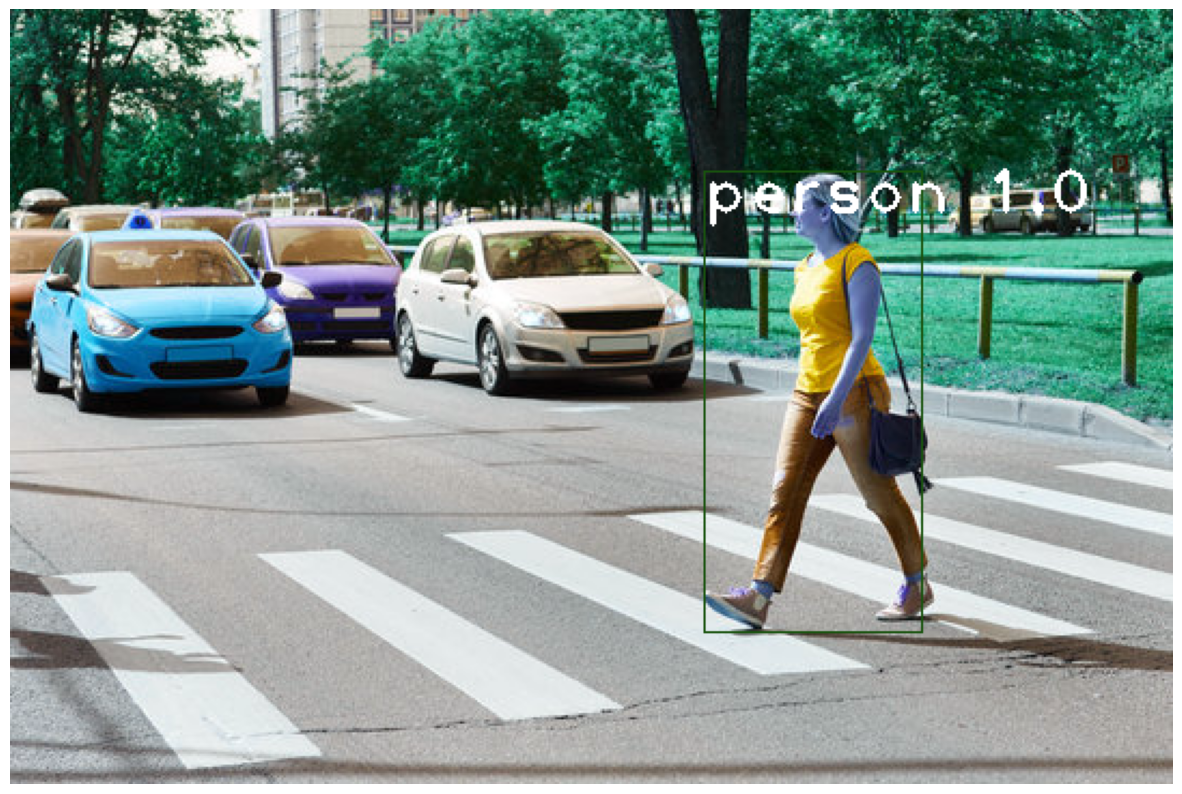

There is / are 1 person(s) in the image


In [80]:
# Call detect pedestrian method
detectPedestrains("woman_crossing.jpeg")